Project 10: Jake Laurie, Zach Lanter, Trevor Packan

Import necessary packages for data analysis

In [1]:
import csv
import os
import webbrowser
import numpy as np
import random
import math
from enum import Enum
from abc import ABC, abstractmethod
from typing import List, Tuple, cast, Dict, Any
from functools import cmp_to_key
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt

Create class for different data types and load and read the csv file 

In [2]:
class DataSetType(Enum):
    CSV = 1

class DataSet(ABC):
    @abstractmethod
    def get_type(self) -> DataSetType:
        pass

    def as_csv(self) -> 'DataSetCSV':
        return cast('DataSetCSV', self)
    
    def as_numpy(self) -> 'DataSetNumpy':
        return cast('DataSetNumpy', self)

class DataSetCSV(DataSet):
    def __init__(self, data: List[List[str]]) -> None:
        self.data = data

    def get_type(self) -> DataSetType:
        return DataSetType.CSV

# Converts a CSV file to a numpy matrix
class DataSetNumpy(DataSet):
    def __init__(self, data:npt.NDArray[np.float64]) -> None:
        self.data = data

    def get_type(self) -> str:
        return 'numpy'

datasets: List[DataSet] = []

# Loading a CSV File
def load_csv() -> None:
    
    file_path: str = 'beer.csv'

    if not os.path.isfile(file_path):
        print(f'Error: File "{file_path}" does not exist.')
        return

    with open(file_path, 'r') as f:
        csv_file = csv.reader(f)
        column_names: List[str] = next(csv_file)
        rows: List[List[str]] = [column_names] 
        for row in csv_file:
            rows.append(row)
        datasets.append(DataSetCSV(rows))

load_csv()


Create functions to help with making basic stats of the data set

In [3]:
def to_number(s: str) -> float:
    s = s.strip()
    if s == '' or s == '?':
        return np.nan
    try:
        return float(s)
    except ValueError:
        return np.nan

# Returns true iff s represents a number
def is_number(s: str) -> bool:
    try:
        float(s)
        return True
    except ValueError:
        return False

# Test if value is numeric
def is_numeric_value(column_data: List[str]) -> bool:
    return all(is_number(value) for value in column_data if value.strip() != '' and value.strip() != 'NA')

def find_min_and_max(data: List[List[str]], col: int) -> Tuple[float, float]:
    min_val = np.nan
    max_val = np.nan
    for i in range(1, len(data)):
        val = to_number(data[i][col])
        if not np.isnan(val):
            min_val = min(val, min_val)
            max_val = max(val, max_val)
    return (min_val, max_val)

# Find the mean of a column
def compute_column_mean(column_data: List[str]) -> float:
    if not is_numeric_value(column_data):
        return np.nan
    
    values: List[float] = [float(value) for value in column_data if value != '' and value != '?']
    sum_values: float = sum(values)
    count_values: int = len(values)
    
    return sum_values / count_values if count_values > 0 else np.nan

def count_missing_values(column_data: List[str]) -> int:
    return sum(1 for value in column_data if value == '' or value == '0.0')
def count_missing_values_categorical(column_data: List[str]) -> int:
    return sum(1 for value in column_data if value == 'NA')


Print the basic stats of the data set

In [4]:
def print_basic_stats() -> None:

    data: List[List[str]] = datasets[-1].as_csv().data

    num_columns: int = len(data[0])
    
    for i in range(num_columns):
        column_data: List[str] = [str(row[i]) for row in data[1:]]  # Convert values to strings
        column_name: str = data[0][i]
        is_numeric: bool = is_numeric_value(column_data)
        print(f'Column "{column_name}" is {"numeric" if is_numeric else "categorical"}.')

        if is_numeric:
            # Fix: Handle 'NA' values by replacing them with a default value
            column_data = [str(val).strip() if val != 'NA' else '0.0' for val in column_data]
            
            min_val, max_val = find_min_and_max(data, i)
            mean_val: float = compute_column_mean(column_data)
            missing_count: int = count_missing_values(column_data)
            print(f'Min: {min_val}, Max: {max_val}, Mean: {mean_val}, Missing Values: {missing_count}')
        else:
            num_unique_values: int = len(set(column_data))
            print(f'Number of Unique Values: {num_unique_values}, Missing Values: {count_missing_values_categorical(column_data)}')

print_basic_stats()

Column "Name" is categorical.
Number of Unique Values: 35, Missing Values: 0
Column "Rating" is categorical.
Number of Unique Values: 3, Missing Values: 0
Column "Origin" is categorical.
Number of Unique Values: 7, Missing Values: 0
Column "Avail" is categorical.
Number of Unique Values: 2, Missing Values: 0
Column "Price" is numeric.
Min: 1.59, Max: 7.19, Mean: 3.0274285714285716, Missing Values: 0
Column "Cost" is numeric.
Min: 0.27, Max: 1.2, Mean: 0.5057142857142857, Missing Values: 0
Column "Calories" is numeric.
Min: 68.0, Max: 175.0, Mean: 139.77142857142857, Missing Values: 0
Column "Sodium" is numeric.
Min: 6.0, Max: 27.0, Mean: 14.657142857142857, Missing Values: 0
Column "Alcohol" is numeric.
Min: 2.3, Max: 5.5, Mean: 4.5771428571428565, Missing Values: 0
Column "Class" is categorical.
Number of Unique Values: 4, Missing Values: 16
Column "Light" is categorical.
Number of Unique Values: 2, Missing Values: 0


To summarize the data, I first had to load the file we are choosing to work with. I looked at past projects to get the code for loading a csv file. After I had the dataset loaded, I used code from past projects to get the code for printing basic statistics. After looking at our csv, I noticed that the missing values were labeled as 'NA', while the formated code had missing values labels as " " or "?". After changing the code so that missing values were counted as 'NA' I was able to get a basic summar of our dataset. 


In [5]:
import plotter

def plot_correlations() -> None:
    data: List[List[str]] = datasets[-1].as_csv().data
    with open('plots.html', 'w') as f:
        f.write('<!DOCTYPE html><html><head>')
        f.write('<meta http-equiv="Content-Type" content="text/html;charset=UTF-8">')
        f.write('<style>')
        f.write('table, th, td {')
        f.write('  border: 4px solid black;')
        f.write('}')
        f.write('big {')
        f.write('  font-size: 30px;')
        f.write('  font-weight: 700;')
        f.write('}')
        f.write('</style></head><body><table>')
        col_count = len(data[0])
        f.write('<tr><td></td>')
        for col in range(col_count):
            f.write(f'<td><big>{data[0][col]}</big></td>')
        f.write('</tr>')
        for col_a in range(col_count):
            f.write(f'<tr><td><big>{data[0][col_a]}</big></td>')
            for col_b in range(col_count):
                f.write('<td>')
                max_points = 2000
                step = max(1, len(data) // max_points)
                if col_a == col_b:
                    if is_numeric_value(data, col_a):
                        p = plotter.plot_histogram([ to_number(data[i][col_a]) for i in range(1, len(data), step)])
                    else:
                        p = plotter.plot_categorical([ data[i][col_a] for i in range(1, len(data), step) ])
                else:
                    num_a = is_numeric_value(data, col_a)
                    num_b = is_numeric_value(data, col_b)
                    if num_a:
                        if num_b:
                            pairs_f_f = [ (to_number(data[i][col_a]), to_number(data[i][col_b])) for i in range(1, len(data), step) ]
                            p = plotter.plot_float_float_pairs(pairs_f_f)
                        else:
                            pairs_f_s = [ (to_number(data[i][col_a]), data[i][col_b]) for i in range(1, len(data), step) ]
                            p = plotter.plot_float_str_pairs(pairs_f_s)
                    else:
                        if num_b:
                            pairs_f_s = [ (to_number(data[i][col_b]), data[i][col_a]) for i in range(1, len(data), step) ]
                            p = plotter.plot_float_str_pairs(pairs_f_s)
                        else:
                            pairs_s_s = [ (data[i][col_a], data[i][col_b]) for i in range(1, len(data), step) ]
                            p = plotter.plot_str_str_pairs(pairs_s_s)
                f.write(p.tostr())
                f.write('</td>')
            f.write('</tr>')
        f.write('</table></body></html>')
    webbrowser.open('plots.html', new=2)

plotting data correlations

In [6]:
from typing import List, Union

def smart_compare(a: Union[str, int], b: Union[str, int]) -> int:
    # Skip whitespace
    a = str(a)
    b = str(b)

    a = a.lstrip()
    b = b.lstrip()

    # Skip matching parts
    while len(a) > 0 and len(b) > 0 and a[0] == b[0]:
        a = a[1:]
        b = b[1:]
    if len(a) == 0:
        if len(b) == 0:
            return 0 # same
        else:
            return -1 # a comes first because it is shorter
    elif len(b) == 0:
        return 1 # b comes first because it is shorter

    # Skip leading zeros
    while len(a) > 0 and a[0] == '0':
        a = a[1:]
    while len(b) > 0 and b[0] == '0':
        b = b[1:]

    # Count digits
    a_count = 0
    while a_count < len(a) and a[a_count].isdigit():
            a_count += 1
    b_count = 0
    while b_count < len(b) and b[b_count].isdigit():
            b_count += 1
    if a_count > 0 and a_count < b_count:
            return -1 # a comes first because it has a shorter leading number
    if b_count > 0 and b_count < a_count:
            return 1 # b comes first because it has a shorter leading number
    
    # Compare alphabetically
    return -1 if a < b else (1 if b < a else 0)

def sort_by_column(data:List[List[str]], col:int) -> List[List[str]]:
    header = data[0]
    sorted_data = sorted(data[1:], key=cmp_to_key(lambda x, y: smart_compare(x[col], y[col]))) # type: ignore
    return [header] + sorted_data

def choose_column_and_sort() -> None:
    data: List[List[str]] = datasets[-1].as_csv().data
    print("Columns:")
    for i, name in enumerate(data[0]):
        print(f'{i}. {name}')
    print('Please choose a column index to sort by:')
    print('> ', end='')
    col_index = int(input())
    newdata = sort_by_column(data, col_index)
    data = data[:-1] + [DataSetCSV(newdata)]

choose_column_and_sort()
for row in datasets[-1].as_csv().data[:10]:
    print(row)


Columns:
0. Name
1. Rating
2. Origin
3. Avail
4. Price
5. Cost
6. Calories
7. Sodium
8. Alcohol
9. Class
10. Light
Please choose a column index to sort by:
> ['Name', 'Rating', 'Origin', 'Avail', 'Price', 'Cost', 'Calories', 'Sodium', 'Alcohol', 'Class', 'Light']
['Budweiser Light', 'Good', 'USA', 'National', '2.63', '0.44', '113', ' 8', '3.7', 'NA', 'Light']
['Coors Light', 'Good', 'USA', 'Regional', '2.73', '0.46', '102', '15', '4.1', 'NA', 'Light']
['Michelob Light', 'Good', 'USA', 'National', '2.99', '0.50', '135', '11', '4.2', 'NA', 'Light']
['Miller Light', 'Good', 'USA', 'National', '2.55', '0.43', ' 99', '10', '4.3', 'NA', 'Light']
['Olympia G. Light', 'Fair', 'USA', 'Regional', '2.75', '0.46', ' 72', ' 6', '2.9', 'NA', 'Light']
['Pabst Ex. Light', 'Fair', 'USA', 'National', '2.29', '0.38', ' 68', '15', '2.3', 'NA', 'Light']
['Schlitz Light', 'Fair', 'USA', 'National', '2.79', '0.47', ' 97', ' 7', '4.2', 'NA', 'Light']
['Anchor Steam', 'VeryGood', 'USA', 'Regional', '7.19', '1.

Sorting dataset by column to see the top values for each column

In [7]:
from decision_tree import Forest


# Copies a dataset
def copy_data(data:List[List[str]]) -> List[List[str]]:
    new_data = []
    column_count = len(data[0])
    for row in range(len(data)):
        old_row = data[row]
        new_row = []
        for col in range(column_count):
            new_row.append(old_row[col])
        new_data.append(new_row)
    return new_data

# Returns a copy of data with the specified column dropped
def data_without_column(data:List[List[str]], drop_col:int) -> List[List[str]]:
    new_data = []
    column_count = len(data[0])
    for row in range(len(data)):
        old_row = data[row]
        new_row = []
        for col in range(column_count):
            if col != drop_col:
                new_row.append(old_row[col])
        new_data.append(new_row)
    return new_data

# Randomly shuffles the order of some data
def shuffle_data(data:List[List[str]]) -> None:
    for i in reversed(range(2, len(data))):
        j = random.randrange(i - 1) + 1
        data[i], data[j] = data[j], data[i]

# Assumes data has no column names.
# Splits data into two parts with the first rows_in_first rows in the first one,
# and the remainder of the rows in the second one.
def split_data(data:List[List[str]], rows_in_first:int) -> Tuple[List[List[str]],List[List[str]]]:
    a = []
    b = []
    column_count = len(data[0])
    for row in range(rows_in_first):
        old_row = data[row]
        new_row = []
        for col in range(column_count):
            new_row.append(old_row[col])
        a.append(new_row)
    for row in range(rows_in_first, len(data)):
        old_row = data[row]
        new_row = []
        for col in range(column_count):
            new_row.append(old_row[col])
        b.append(new_row)
    return a, b
# Performs several trials of training a random forest and measuring its accuracy.
# Returns the mean-squared error if label_col is numerical,
# or the mean misclassifications if label_col is categorical.
def measure_error(train_data:List[List[str]], test_data:List[List[str]], label_col:int, trials:int=3) -> float:
    # Determine whether the label column is numerical or categorical
    numerical = True
    for i in range(len(test_data)):
        if not is_number(test_data[i][label_col]):
            numerical = False
            break
        # Perform the training and testing trials
    err = 0.
    for trial in range(trials):
        # Train
        forest = Forest(train_data, label_col)
        # Test
        for row in test_data:
            pred = forest.predict(row)
            if numerical:
                err += ((to_number(pred) - to_number(row[label_col])) ** 2)
            else:
                err += 0. if pred == row[label_col].strip() else 1.
    # Return the average error
    return err / (trials * len(test_data))
def rank_attributes() -> None:
    data: List[List[str]] = datasets[-1].as_csv().data
    shuffle_data(data)

    # Show the columns
    print('Available columns:')
    for i, col in enumerate(data[0]):
        print(f'{i}. {col}')

    # Ask the user to select a column
    print('\nPlease choose a column to predict (enter the index)')
    print('> ', end='')
    label_column = int(input())
    # Drop the column names
    data_without_names = data[1:]

    # Split into train and test portions
    train, test = split_data(data_without_names, len(data_without_names) // 2)

    # Measure error
    error = measure_error(train, test, label_column)
    print(f'Predicting {label_column}: {data[0][label_column]}, error={error}')

    # Rank attributes
    attribute_names = data[0][:]
    base_error = measure_error(train, test, label_column)
    while len(attribute_names) > 1:
        min_error_increase = float('inf')
        min_error_increase_attribute = None
        for attribute in attribute_names:
            attribute_index = data[0].index(attribute)
            data_without_attribute = data_without_column(data, attribute_index)
            if attribute_index < label_column:
                label_column -= 1
            train, test = split_data(data_without_attribute, len(data_without_attribute) // 2)
            error = measure_error(train, test, label_column)
            error_increase = error - base_error
            if error_increase < min_error_increase:
                min_error_increase = error_increase
                min_error_increase_attribute = attribute
        if min_error_increase_attribute is not None:
            attribute_names.remove(min_error_increase_attribute)
        print(f'Dropped attribute: {min_error_increase_attribute}, error increase={min_error_increase}')

rank_attributes()


Available columns:
0. Name
1. Rating
2. Origin
3. Avail
4. Price
5. Cost
6. Calories
7. Sodium
8. Alcohol
9. Class
10. Light

Please choose a column to predict (enter the index)
> Predicting 3: Avail, error=0.2962962962962963
Dropped attribute: Rating, error increase=-0.16666666666666669
Dropped attribute: Name, error increase=0.5
Dropped attribute: Origin, error increase=0.7222222222222222
Dropped attribute: Avail, error increase=0.7222222222222222
Dropped attribute: Price, error increase=0.7222222222222222
Dropped attribute: Cost, error increase=0.7222222222222222
Dropped attribute: Calories, error increase=0.7222222222222222
Dropped attribute: Sodium, error increase=0.7222222222222222
Dropped attribute: Alcohol, error increase=0.7222222222222222
Dropped attribute: Class, error increase=0.7222222222222222


Ranking attributes based on how well they can predict another attribute

Conducting principal component analysis to reduce data table to its essential features

In [8]:
def is_numeric(data: List[List[str]], col: int) -> bool:
    for i in range(1, len(data)):
        value = str(data[i][col])
        if not value.replace(".", "", 1).isdigit():
            return False
    return True
    
def load_csv_to_numpy() -> None:
    data: List[List[str]] = datasets[-1].as_csv().data
    csv = data
    col_count = len(csv[0])

    col_matrices:List[npt.NDArray[np.float64]] = []
    for col_index in range(col_count):
        if is_numeric(csv, col_index):
            col_matrix = numeric_col_to_numpy_matrix(csv, col_index)
        else:
            col_matrix = categorical_col_to_numpy_matrix(csv, col_index)
            
        col_matrices.append(col_matrix)
    all_cols = np.concatenate(col_matrices, axis=1)
    datasets.append(DataSetNumpy(all_cols))

def numeric_col_to_numpy_matrix(csv: List[List[str]], col_index: int) -> npt.NDArray[np.float64]:
    
    n = len(csv) - 1
    col = np.empty((n,1), dtype = np.float64)

    for i in range(n):
        col[i, 0] = to_number(csv[i+1][col_index])
    return col


# Converts a categorical column in a CSV file to a one-hot representation in a numpy matrix
def categorical_col_to_numpy_matrix(csv:List[List[str]], col_index:int) -> npt.NDArray[np.float64]:
    d: Dict[str, int] = {}
    for row in csv[1:]:
        if not row[col_index] in d:
            d[row[col_index]] = len(d)
    n = len(csv) - 1
    col = np.empty(n, dtype=np.int64)
    for i in range(n):
        col[i] = d[csv[i+1][col_index]]

    return one_hot(col)


# Input: A one-dimensional array of zero-indexed integer values that indicate categories.
# Output: A two-dimensional one-hot (binary) encoding of the same values.
def one_hot(bef: npt.NDArray[Any]) -> npt.NDArray[np.float64]:
    assert len(bef.shape) == 1, f"Expected a one-dimenstional array of integer values. Got shape={bef.shape}"
    vals = bef.max() + 1
    aft = np.zeros((bef.shape[0], vals), dtype=np.float64)
    aft[np.arange(bef.shape[0]), bef] = 1.0
    return aft

def center_data(data: npt.NDArray[np.float64]) -> npt.NDArray[np.float64]:
    return data - np.mean(data, axis=0) #type: ignore

def standardize_data(data: npt.NDArray[np.float64]) -> npt.NDArray[np.float64]:
    return center_data(data) / np.std(data, axis=0) #type: ignore


# Normalizes a vector
def normalize(v:npt.NDArray[np.float64]) -> npt.NDArray[np.float64]:
    norm = np.linalg.norm(v)
    if norm == 0:
       return np.ones(v.shape[0]) * math.sqrt(1. / v.shape[0])
    return v / norm

# x is a matrix where each row is a sample vector.
# Returns the first principal component of x about the origin.
def first_principal_component(x:npt.NDArray[np.float64]) -> npt.NDArray[np.float64]:
    assert len(x.shape) == 2
    fpc = np.random.normal(0., 1., size=(x.shape[-1],))
    mag = 0. # How much correlation the previous iteration had
    for iters in range(200):
        a = np.sum((x @ fpc).reshape((-1, 1)) * x, axis=0) # Accumulated correlation
        fpc = normalize(a)
        cur_mag = np.sum(a * a).astype(float) # How much correlation this iteration had
        if iters < 6 or mag - cur_mag > 1e-8:
            mag = cur_mag
        else:
            break # We have converged
    return fpc

# x is a dataset, where each row is a sample.
# component is a standardized principal component of x.
# Returns y, e,
# where y is the matrix x with component subtracted out of it,
# and e is the eigenvalue that indicates the variance of x in the component direction.
def remove_component(x:npt.NDArray[np.float64], component:npt.NDArray[np.float64]) -> Tuple[npt.NDArray[np.float64], float]:
    assert len(x.shape) == 2, "Expected x to have two dimensions"
    assert len(component.shape) == 1, "Expected component to have one dimension"
    data_comp = (x @ component).reshape((-1, 1)) * component
    return x - data_comp, np.sum(data_comp * data_comp) / (x.shape[0] - 1)

def principal_component_analysis() -> None:
    data: List[List[str]] = datasets[-1].as_csv().data
    data_copy = standardize_data(center_data(data))

    # Compute the eigenvalues
    eigs:List[float] = []
    for _ in range(data.shape[1]):
        component = first_principal_component(data_copy)
        data_copy, eigenvalue = remove_component(data_copy, component)
        eigs.append(eigenvalue)

    # Plot the square roots of the eigenvalues
    devs = [ math.sqrt(eig) for eig in eigs ]
    p = plotter.Plotter((800, 450), (0., 0.), (len(devs) + 1, max(devs)))
    print('Root eigenvalues:')
    for i, dev in enumerate(devs):
        print(f'{i}: {dev}')
        p.rect((i + 0.1, 0), (i + 0.9, dev), (0, 128, 255))
        p.text(f'{dev:.03f}', (i + 0.1, 0.), 16, (64, 0, 0))
    p.tosvg('eigs.svg')
    webbrowser.open(f'eigs.svg', new=2)

load_csv_to_numpy()
principal_component_analysis()


Root eigenvalues:
0: 2.4420350798128414
1: 2.6220927688182423
2: 2.277705775178748
3: 2.005278504122292
4: 1.895509521131224
5: 1.9954715624320059
6: 1.989946094617195
7: 1.866743318667801
8: 1.8718559978676463
9: 1.865242338160004
10: 1.7783636725137464
11: 1.7452388166149377
12: 1.7153702039308503
13: 1.7248222867755063
14: 1.6713065568457754
15: 1.7364230366478983
16: 1.6046598538419246
17: 1.6355484515784198
18: 1.5518180497422287
19: 1.5219786006063298
20: 1.5666916386606988
21: 1.4746957745454758
22: 1.4673569739571073
23: 1.4291753612685532
24: 1.3367775942465092
25: 1.4682720540548904
26: 1.3947653677322347
27: 1.2709239644864818
28: 1.2325741809772184
29: 1.2371727701294124
30: 1.1719093074927744
31: 1.1787949670302014
32: 1.1723137650001143
33: 1.1357595110876781
34: 9.794513833694148e-16
35: 7.575203770851218e-16
36: 8.176244469214217e-16
37: 7.530398115889501e-16
38: 7.124725952426537e-16
39: 6.944183961984085e-16
40: 6.627063430627966e-16
41: 5.902835218617496e-16
42: 6.51

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('beer.csv')

print(data[:5])  # Print the first 5 elements in the data variable




               Name Rating Origin     Avail  Price  Cost  Calories  Sodium  \
0   Budweiser Light   Good    USA  National   2.63  0.44       113       8   
1       Coors Light   Good    USA  Regional   2.73  0.46       102      15   
2    Michelob Light   Good    USA  National   2.99  0.50       135      11   
3      Miller Light   Good    USA  National   2.55  0.43        99      10   
4  Olympia G. Light   Fair    USA  Regional   2.75  0.46        72       6   

   Alcohol Class  Light  
0      3.7   NaN  Light  
1      4.1   NaN  Light  
2      4.2   NaN  Light  
3      4.3   NaN  Light  
4      2.9   NaN  Light  


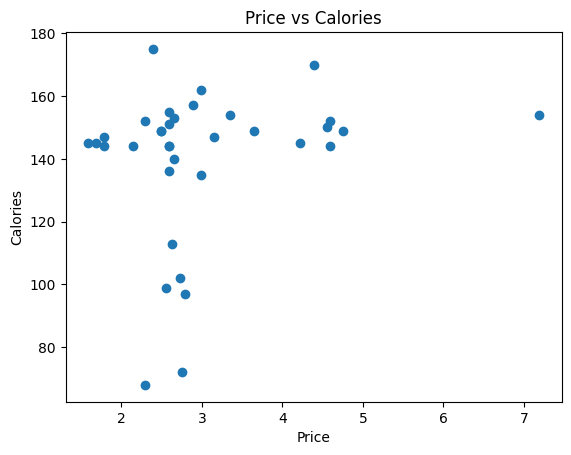

In [25]:
import matplotlib.pyplot as plt

# Plotting the Price column against the Calories column
plt.scatter(data['Price'], data['Calories'])
plt.xlabel('Price')
plt.ylabel('Calories')
plt.title('Price vs Calories')
plt.show()


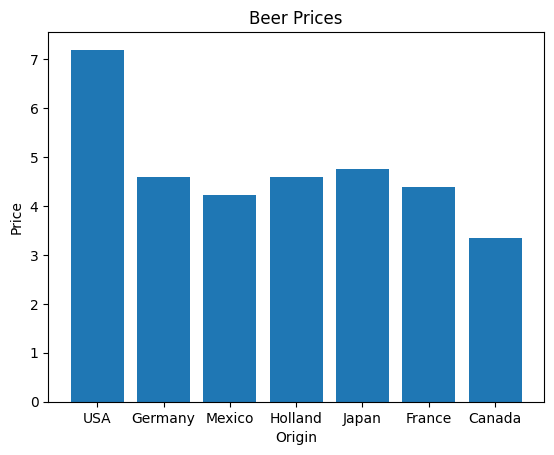

In [24]:
import matplotlib.pyplot as plt

# Extracting the data from the 'data' variable
x = data['Origin']
y = data['Price']

# Creating the plot
plt.bar(x, y)
plt.xlabel('Origin')
plt.ylabel('Price')
plt.title('Beer Prices')
plt.show()


After summarizing, cleaning, plotting, and analyzing the data. We were able to find different patterns in the dataset that allowed us to make insights. The amount of values in the dataset was found. The average values of each of the columns and what the max and min were. Some interesting things were how th minimum price and cost had ratio of 0.17 while max price to cost was 0.30. We also were able to make a correlation plot that helped with ranking attributes based on how well they could predict others. We found the best way to predict cost is by finding how much alcohol there is. Finally using principal component analysis to reduce number of variables in dataset while also preserving most of information.

In [ ]:
def compute_mean(data: List[List[str]], col_index:int) -> int:
    sum = 0
    count = 0
    for row in data[1:]:
        value = row[col_index]
        if value != 'NA':
            sum += int(value)
            count += 1
    return sum / count